# Florence 2 Object Detection Finetuning

In [2]:
# - Packages
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from torch.utils.data import Dataset, DataLoader

import torch
import supervision as sv

from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)

from peft import LoraConfig, get_peft_model

In [7]:
# - Global Variables
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
raw_image_slice_dir = data_dir / 'image_slice_pngs'
seg_image_slice_dir = data_dir / 'seg_slice_pngs'
os.makedirs(raw_image_slice_dir, exist_ok=True)
os.makedirs(seg_image_slice_dir, exist_ok=True)
itrs = 10000

# CHECKPOINT = "microsoft/Florence-2-base-ft"
# REVISION = 'refs/pr/6'

CHECKPOINT = "microsoft/Florence-2-large-ft"
REVISION = 'refs/pr/19'


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_num = 170

## - Define Dataloader
BATCH_SIZE = 2
NUM_WORKERS = 0

## - Lora config
rank = 8
alpha = 8

EPOCHS = 10000
LR = 5e-6

## - Model Initialization

# model = AutoModelForCausalLM.from_pretrained(
#     CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
# processor = AutoProcessor.from_pretrained(
#     CHECKPOINT, trust_remote_code=True, revision=REVISION)


## Prepare Dataset and Initialize Dataset and Dataloader

In [8]:
# - Finetuning Dataset Processing
## - Prepare dataset
data = []
for ff, name in enumerate(os.listdir(raw_image_dir)):
    data.append({'image': raw_image_dir / f'image{ff:04d}.png', 'annotation': seg_image_dir / f'seg{ff:04d}.png'})
# - split train dataset and validation dataset
valid_data = data[80:]
data = data[:80]

In [9]:
# - slice image and segmentation for florence sequence length limit
def create_slices(image_path, slice_image_dir):
    img = Image.open(image_path)
     # Get image dimensions
    width, height = img.size
    
    # Calculate the midpoint
    mid_x, mid_y = width // 2, height // 2
    
    # Define the four slices (left, upper, right, lower)
    slices = {
        'top_left': (0, 0, mid_x, mid_y),
        'top_right': (mid_x, 0, width, mid_y),
        'bottom_left': (0, mid_y, mid_x, height),
        'bottom_right': (mid_x, mid_y, width, height)
    }
    
    # Loop through the slices, crop, and save them
    all_slices = []
    for key, coords in slices.items():
        slice_img = img.crop(coords)
        # Format the name: base name + coordinates
        slice_filename = f"{image_path.stem}_{coords[0]}_{coords[1]}_{coords[2]}_{coords[3]}.png"
        slice_img.save( raw_image_slice_dir / slice_filename)
        all_slices.append( raw_image_slice_dir / slice_filename)

    return all_slices

def slice_all_image_seg(data, raw_image_slice_dir, seg_image_slice_dir):
    new_data = []
    for element in data:
        image_path = element['image']
        seg_path = element['annotation']
        image_lst = create_slices(image_path, raw_image_dir)
        seg_lst = create_slices(seg_path, seg_image_slice_dir)

        for i in range(len(image_lst)):
            new_data.append({'image': image_lst[i], 'annotation': seg_lst[i]})
        
    return new_data

data = slice_all_image_seg(data, raw_image_slice_dir, seg_image_slice_dir)
valid_data = slice_all_image_seg(valid_data, raw_image_slice_dir, seg_image_slice_dir)


In [10]:

## - Convert Mask to Bounding Boxes
def convert_mask2box(mask:np.ndarray):
    inds = np.unique(mask)[1:] # load all indices

    masks = [] 
    for ind in inds:
        masks.append(mask == ind)

    masks = np.array(masks)
    masks_tensor = torch.from_numpy(masks)

    boxes = masks_to_boxes(masks_tensor)
    valid_input_boxes = boxes.numpy()
    return valid_input_boxes

## - normalize location
def normalize_loc(prefix:str, instance_type:str, image_path:str, mask:np.ndarray, input_boxes:np.ndarray):
    x_res = mask.shape[0]
    y_res = mask.shape[1]
    normal_boxes = [[box[0] / x_res * 1000, box[1]/ y_res * 1000, box[2] / x_res * 1000, box[3] / x_res * 1000] for box in input_boxes]
    normal_boxes = np.rint(normal_boxes)
    suffix = ''
    count = 0
    for i in range(len(normal_boxes)):
        #- reach the max sequence length 1024
        if count == label_num:
            break
        x1 = int(normal_boxes[i][0])
        y1 = int(normal_boxes[i][1])
        x2 = int(normal_boxes[i][2])
        y2 = int(normal_boxes[i][3])
        suffix += f"{instance_type}<loc_{x1}><loc_{y1}><loc_{x2}><loc_{y2}>"
        count += 1
        
    print(count)
    
    return {"image": image_path,"prefix": prefix, "suffix": suffix }

## - Prepare all training dataset and validation dataset
def prepare_dataset(data, instance_type, prefix):
    dataset = []
    for element in data:
        image_path = element['image']
        seg_path = element['annotation']
        mask = np.array(Image.open(seg_path))
        input_boxes = convert_mask2box(mask)
        curated_data = normalize_loc(prefix, instance_type, image_path, mask, input_boxes)
        dataset.append(curated_data)
    return dataset

train_dataset = prepare_dataset(data, 'neuron', "<OD>")
val_dataset = prepare_dataset(valid_data, 'neuron', "<OD>")


82
69
48
58
81
70
50
60
82
71
51
57
81
69
52
58
79
69
53
58
81
70
55
62
80
69
55
63
80
69
55
65
81
67
57
65
78
64
60
63
77
65
61
63
80
66
60
63
79
68
59
63
76
69
61
63
73
69
60
62
72
67
59
62
71
68
62
62
72
69
62
65
72
69
62
62
71
67
61
61
70
66
65
64
73
66
65
63
72
67
65
63
73
67
64
63
74
67
64
64
75
66
64
67
76
65
65
66
76
65
64
64
76
64
64
65
75
63
63
65
76
60
63
64
76
60
63
64
78
59
63
66
80
59
63
66
79
58
65
66
77
56
64
65
78
55
62
67
78
56
61
66
76
55
60
66
75
53
60
66
74
51
58
65
72
50
60
65
74
50
61
65
73
51
60
66
73
52
61
66
74
53
61
64
75
55
60
63
76
57
59
62
77
57
60
62
78
56
60
64
77
59
61
64
80
59
59
65
76
59
58
65
76
60
58
65
74
60
57
65
72
59
59
65
72
56
59
65
73
57
60
67
70
59
60
68
72
58
59
68
72
58
61
67
70
56
64
69
68
56
64
70
67
56
62
71
68
58
64
71
67
58
64
70
67
57
66
68
67
56
66
69
66
57
66
70
66
57
66
70
67
57
64
71
67
59
63
71
67
59
65
71
70
60
65
71
72
60
65
72
71
63
65
72
70
64
65
71
74
64
67
69
75
66
65
71
76
66
65
71
75
66
64
72
73
69
63
72
73
69
64
71
74
7

In [18]:
# - Initialize Dataset and Dataloader

## - Detection Dataset Class (Dataset Preparation)
class DetectionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = cv2.imread(str(data['image']))
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

## - Define Dataloader

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(train_dataset)
val_dataset = DetectionDataset(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False)

## Image Visualization and Finetuning Process

In [19]:
# - Lora Finetuning Configuration

TARGET_MODULES = [
    "q_proj", "o_proj", "k_proj", "v_proj", 
    "linear", "Conv2d", "lm_head", "fc2"
]

config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    target_modules=TARGET_MODULES,
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 826,827,464 || trainable%: 0.4999



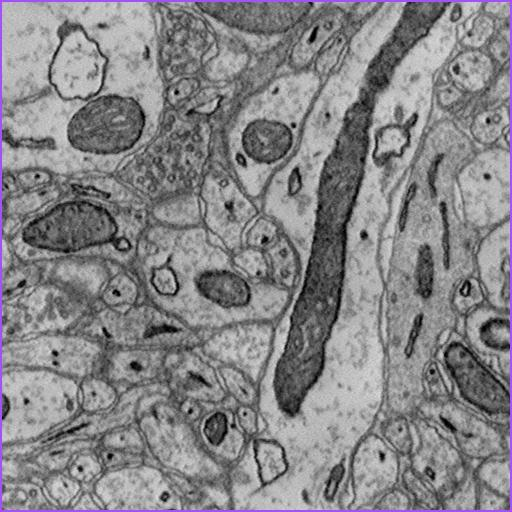
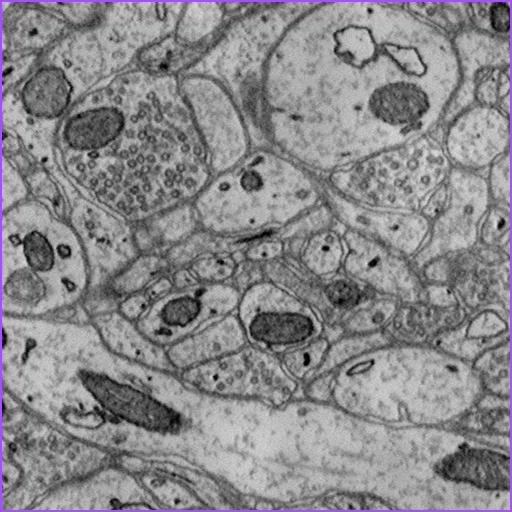
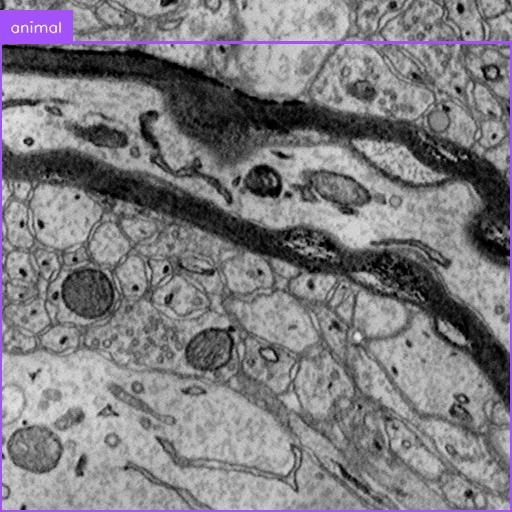
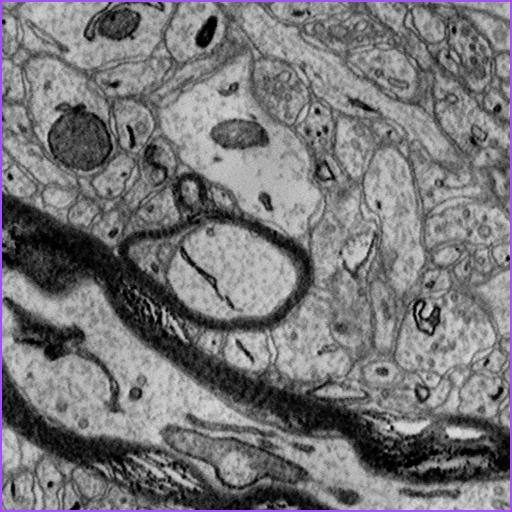

In [20]:
# - Image HTML Visualization
# @title Run inference with pre-trained Florence-2 model on validation dataset
import io
import base64
import html
import json
from IPython.display import HTML
def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        data = dataset.dataset[i]
        image = cv2.imread(str(data['image']))
        image = Image.fromarray(image)
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)


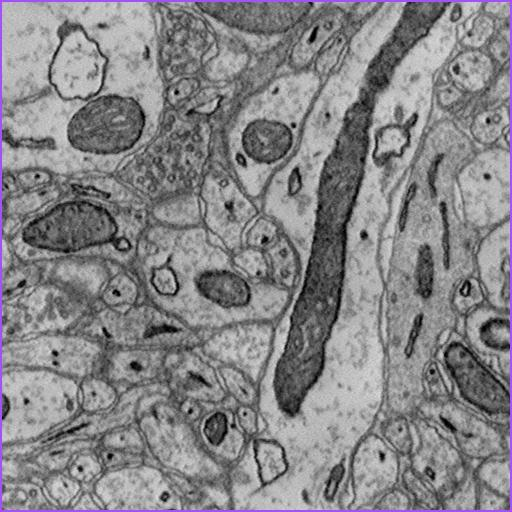
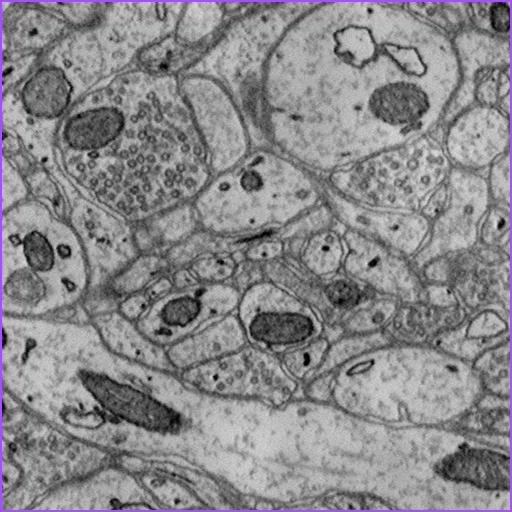
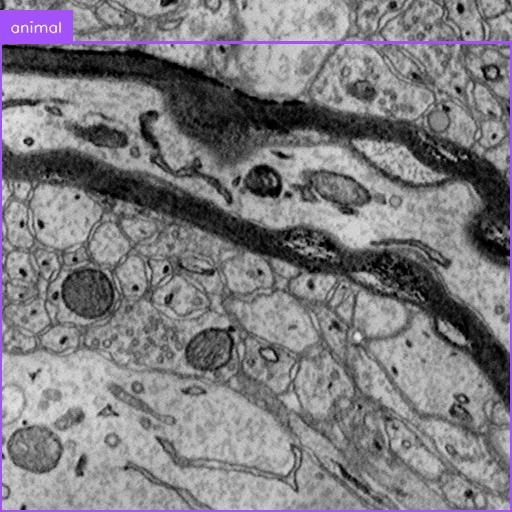
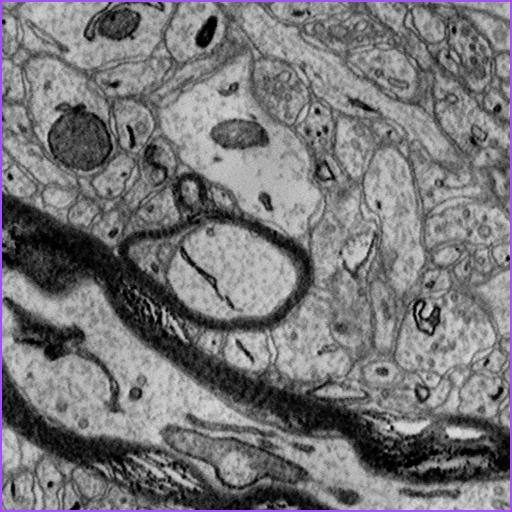
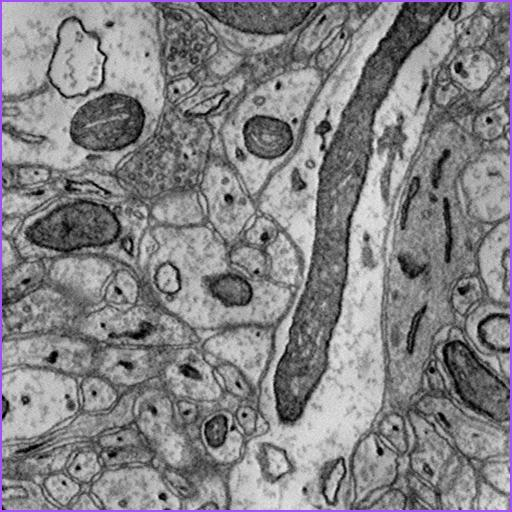
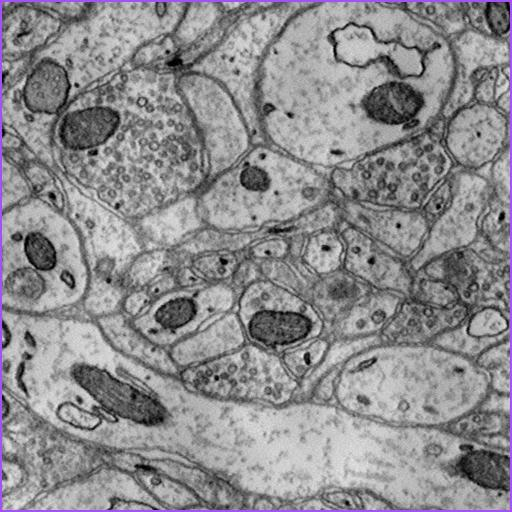

Training Epoch 1/10000:  16%|█▌        | 25/160 [00:23<02:05,  1.08it/s]


KeyboardInterrupt: 

In [21]:
# - Training Process
# - define training loop
from tqdm import tqdm
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            if (epoch + 1) % 100 == 0:
                render_inference_results(peft_model, val_loader.dataset, 6)
                
        if (epoch+1) % 100 == 0:
            output_dir = f"./model_checkpoints/large_model/epoch_{epoch+1}"
            os.makedirs(output_dir, exist_ok=True)
            model.save_pretrained(output_dir)
            processor.save_pretrained(output_dir)
            
train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)